# UNet
### 400 * 4 operation

In [1]:
from pathlib import Path
DATA = DATA = Path('/home/paperspace/ssdd')

In [2]:
BS = 6
#LR = 5e-3
EPOCHS = 40
MODEL_NAME = "senet154"
REMARK = "_"
THRESHOLD = 0.5
CUT_HORI = True

MODEL_PTH = "ssdd_%s_b%s%s.pth"%(MODEL_NAME,BS,REMARK)

Choices of model names

### VGG
vgg11, vgg13, vgg16, vgg19, vgg11bn, vgg13bn, vgg16bn, vgg19bn,
### Densenet
densenet121, densenet169, densenet201, densenet161, dpn68, dpn98, dpn131,
### Resnet
inceptionresnetv2,
resnet18, resnet34, resnet50, resnet101, resnet152,
resnext50_32x4d, resnext101_32x8d,
### SeNet
se_resnet50, se_resnet101, se_resnet152,
se_resnext50_32x4d, se_resnext101_32x4d,
senet154,
#### EfficientNet
efficientnet-b0, efficientnet-b1, efficientnet-b2, efficientnet-b3, efficientnet-b4, efficientnet-b5, efficientnet-b6, efficientnet-b7


In [3]:
import segmentation_models_pytorch as smp

In [4]:
import os
import cv2
import pdb
import time
import warnings
import random
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler

from matplotlib import pyplot as plt

from albumentations import (HorizontalFlip, RGBShift, ElasticTransform, GridDistortion,RandomBrightness ,ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
from albumentations.pytorch import ToTensor
#warnings.filterwarnings("ignore")

In [5]:
seed = 69
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

### RLE-Mask utility functions

In [6]:
def mask2rle(img):
    '''
    Numpy image to run length encoding
    img: numpy array, 1 -> mask, 0 -> background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def make_mask(row_id, df):
    '''Given a row index, return image_id and mask (256, 1600, 4) from the dataframe `df`'''
    fname = df.iloc[row_id].name
    labels = df.iloc[row_id][:4]
    masks = np.zeros((256, 1600, 4), dtype=np.float32) # float32 is V.Imp
    # 4:class 1～4 (ch:0～3)

    for idx, label in enumerate(labels.values):
        if label is not np.nan:
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            mask = np.zeros(256 * 1600, dtype=np.uint8)
            for pos, le in zip(positions, length):
                mask[pos:(pos + le)] = 1
            masks[:, :, idx] = mask.reshape(256, 1600, order='F')
    return fname, masks

### DataLoader

In [7]:
class SteelDataset(Dataset):
    def __init__(self, df, data_folder, mean, std, phase):
        self.df = df
        self.root = data_folder
        self.mean = mean
        self.std = std
        self.phase = phase
        self.transforms = get_transforms(phase, mean, std)
        self.fnames = self.df.index.tolist()

    def __getitem__(self, idx):
        image_id, mask = make_mask(idx, self.df)
        image_path = os.path.join(self.root, "train_images",  image_id)
        img = cv2.imread(image_path)
        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image'] # 1x256x1600
        mask = augmented['mask'] # 1x256x1600x4
        mask = mask[0].permute(2, 0, 1) # 1x4x256x1600
        return img, mask

    def __len__(self):
        return len(self.fnames)
        


def get_transforms(phase, mean, std):
    list_transforms = []
    if phase == "train":
        list_transforms.extend(
            [
                HorizontalFlip(p=0.5), # only horizontal flip as of now
                RGBShift(),
                ElasticTransform(),
                GridDistortion(), 
                RandomBrightness(),
            ]
        )
    list_transforms.extend(
        [
            Normalize(mean=mean, std=std, p=1),
            ToTensor(),
        ]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms

def provider(
    data_folder,
    df_path,
    phase,
    mean=None,
    std=None,
    batch_size=BS,
    num_workers=4,
):
    '''Returns dataloader for the model training'''
    df = pd.read_csv(df_path)
    # https://www.kaggle.com/amanooo/defect-detection-starter-u-net
    df['ImageId'], df['ClassId'] = zip(*df['ImageId_ClassId'].str.split('_'))
    df['ClassId'] = df['ClassId'].astype(int)
    df = df.pivot(index='ImageId',columns='ClassId',values='EncodedPixels')
    df['defects'] = df.count(axis=1)
    
    train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["defects"], random_state=69)
    df = train_df if phase == "train" else val_df
    image_dataset = SteelDataset(df, data_folder, mean, std, phase)
    dataloader = DataLoader(
        image_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,   
    )

    return dataloader

### Utility function

#### Dice and IoU metric implementations, metric logger for training and validation.

In [8]:
def predict(X, threshold):
    '''X is sigmoid output of the model'''
    X_p = np.copy(X)
    preds = (X_p > threshold).astype('uint8')
    return preds

def metric(probability, truth, threshold=THRESHOLD, reduction='none'):
    '''Calculates dice of positive and negative images seperately'''
    '''probability and truth must be torch tensors'''
    batch_size = len(truth)
    with torch.no_grad():
        probability = probability.view(batch_size, -1)
        truth = truth.view(batch_size, -1)
        assert(probability.shape == truth.shape)

        p = (probability > threshold).float()
        t = (truth > 0.5).float()

        t_sum = t.sum(-1)
        p_sum = p.sum(-1)
        neg_index = torch.nonzero(t_sum == 0)
        pos_index = torch.nonzero(t_sum >= 1)

        dice_neg = (p_sum == 0).float()
        dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1))

        dice_neg = dice_neg[neg_index]
        dice_pos = dice_pos[pos_index]
        dice = torch.cat([dice_pos, dice_neg])

        dice_neg = np.nan_to_num(dice_neg.mean().item(), 0)
        dice_pos = np.nan_to_num(dice_pos.mean().item(), 0)
        dice = dice.mean().item()

        num_neg = len(neg_index)
        num_pos = len(pos_index)

    return dice, dice_neg, dice_pos, num_neg, num_pos

class Meter:
    '''A meter to keep track of iou and dice scores throughout an epoch'''
    def __init__(self, phase, epoch):
        self.base_threshold = 0.5 # <<<<<<<<<<< here's the threshold
        self.base_dice_scores = []
        self.dice_neg_scores = []
        self.dice_pos_scores = []
        self.iou_scores = []

    def update(self, targets, outputs):
        probs = torch.sigmoid(outputs)
        dice, dice_neg, dice_pos, _, _ = metric(probs, targets, self.base_threshold)
        self.base_dice_scores.append(dice)
        self.dice_pos_scores.append(dice_pos)
        self.dice_neg_scores.append(dice_neg)
        preds = predict(probs, self.base_threshold)
        iou = compute_iou_batch(preds, targets, classes=[1])
        self.iou_scores.append(iou)

    def get_metrics(self):
        dice = np.mean(self.base_dice_scores)
        dice_neg = np.mean(self.dice_neg_scores)
        dice_pos = np.mean(self.dice_pos_scores)
        dices = [dice, dice_neg, dice_pos]
        iou = np.nanmean(self.iou_scores)
        return dices, iou

def epoch_log(phase, epoch, epoch_loss, meter, start):
    '''logging the metrics at the end of an epoch'''
    dices, iou = meter.get_metrics()
    dice, dice_neg, dice_pos = dices
    print("Loss: %0.4f | IoU: %0.4f | dice: %0.4f | dice_neg: %0.4f | dice_pos: %0.4f" % (epoch_loss, iou, dice, dice_neg, dice_pos))
    return dice, iou

def compute_ious(pred, label, classes, ignore_index=255, only_present=True):
    '''computes iou for one ground truth mask and predicted mask'''
    pred[label == ignore_index] = 0
    ious = []
    for c in classes:
        label_c = label == c
        if only_present and np.sum(label_c) == 0:
            ious.append(np.nan)
            continue
        pred_c = pred == c
        intersection = np.logical_and(pred_c, label_c).sum()
        union = np.logical_or(pred_c, label_c).sum()
        if union != 0:
            ious.append(intersection / union)
    return ious if ious else [1]

def compute_iou_batch(outputs, labels, classes=None):
    '''computes mean iou for a batch of ground truth masks and predicted masks'''
    ious = []
    preds = np.copy(outputs) # copy is imp
    labels = np.array(labels) # tensor to np
    for pred, label in zip(preds, labels):
        ious.append(np.nanmean(compute_ious(pred, label, classes)))
    iou = np.nanmean(ious)
    return iou

def cutHorizontal(x):
    return torch.cat(list(x[...,i*400:(i+1)*400] for i in range(4)), dim=0)

def to416(x):
    size = list(x.size())
    size[-1]=416
    new = torch.zeros(size)
    new[...,8:-8] = x
    return new

In [9]:
model = smp.FPN(MODEL_NAME, encoder_weights="imagenet", classes=4, activation=None)

In [10]:
trainloader = provider(
                data_folder= DATA,
                df_path= DATA/'train.csv',
                phase='train',
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                batch_size=6,
                num_workers=6,
            )

valloader = provider(
                data_folder= DATA,
                df_path= DATA/'train.csv',
                phase='val',
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                batch_size=6,
                num_workers=6,
            )

/home/paperspace/anaconda3/envs/fastai/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


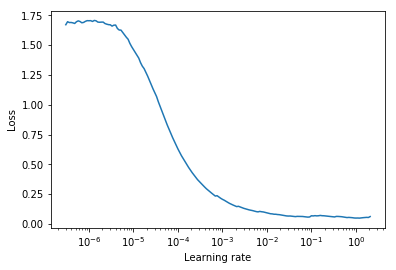

In [11]:
from torch_lr_finder import LRFinder

#model = smp.Unet("efficientnet-b5", encoder_weights="imagenet", classes=4, activation=None)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-3)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot()